DEAP Arousal Prediction - Optimized Version
============================================
Advanced implementation with:
- Caching for faster data loading
- Advanced feature extraction (Hjorth parameters, fractal dimension)
- Hyperparameter optimization
- Ensemble methods for better performance


In [5]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Set paths
DATA_PATH = '/content/drive/My Drive/DeapDb/data_preprocessed_python'
CACHE_PATH = '/content/drive/My Drive/DeapDb/cache'
RAW_CACHE_PATH = '/content/drive/My Drive/DeapDb/raw_cache'

os.makedirs(CACHE_PATH, exist_ok=True)
os.makedirs(RAW_CACHE_PATH, exist_ok=True)

print(f"Data path: {DATA_PATH}")
print(f"Cache path: {CACHE_PATH}")
print(f"Raw cache path: {RAW_CACHE_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data path: /content/drive/My Drive/DeapDb/data_preprocessed_python
Cache path: /content/drive/My Drive/DeapDb/cache
Raw cache path: /content/drive/My Drive/DeapDb/raw_cache


In [6]:
NUM_SUBJECTS = 32
USE_CACHE = True
USE_ADVANCED_FEATURES = True
N_JOBS = 4

In [58]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import (StratifiedKFold, KFold, GridSearchCV,
                                   RandomizedSearchCV, cross_validate, cross_val_predict)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, mean_squared_error, mean_absolute_error,
                           r2_score, classification_report)
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import VotingClassifier, VotingRegressor

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


# Progress tracking
from tqdm import tqdm
import multiprocessing as mp
from functools import partial
import joblib
import hashlib
import time

# Feature Extraction Functions

In [8]:
def hjorth_parameters(signal_data):
    """Calculate Hjorth parameters (Activity, Mobility, Complexity)."""
    activity = np.var(signal_data)
    diff1 = np.diff(signal_data)
    diff2 = np.diff(diff1)
    mobility = np.sqrt(np.var(diff1) / (activity + 1e-10))
    complexity = np.sqrt(np.var(diff2) / (np.var(diff1) + 1e-10)) / (mobility + 1e-10)
    return activity, mobility, complexity

def higuchi_fractal_dimension(signal_data, k_max=10):
    """Calculate Higuchi Fractal Dimension of a signal."""
    N = len(signal_data)
    L = []
    for k in range(1, k_max + 1):
        Lk = []
        for m in range(k):
            Lm = 0
            for i in range(1, int(np.floor((N - m) / k))):
                Lm += abs(signal_data[m + i * k] - signal_data[m + (i - 1) * k])
            Lm = Lm * (N - 1) / (k * int(np.floor((N - m) / k)) * k)
            Lk.append(Lm)
        L.append(np.mean(Lk))

    x = np.log(1 / np.arange(1, k_max + 1))
    y = np.log(L)
    valid_idx = np.isfinite(x) & np.isfinite(y)
    if np.sum(valid_idx) < 2:
        return 1.0
    coeffs = np.polyfit(x[valid_idx], y[valid_idx], 1)
    return coeffs[0]

def spectral_entropy(signal_data, fs=128):
    """Calculate spectral entropy of signal."""
    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)))
    psd_norm = psd / (np.sum(psd) + 1e-10)
    entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))
    return entropy

def extract_advanced_features(trial_data, fs=128):
    """Extract comprehensive feature set (FROM YOUR NOTEBOOK - unchanged)."""
    n_channels = min(trial_data.shape[1], 32) if len(trial_data.shape) > 1 else 1

    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }

    all_features = []

    for ch in range(n_channels):
        channel_data = trial_data[:, ch] if len(trial_data.shape) > 1 else trial_data

        # Band Powers
        freqs, psd = signal.welch(channel_data, fs=fs, nperseg=min(256, len(channel_data)))
        band_powers = {}

        for band_name, (low, high) in bands.items():
            band_idx = np.logical_and(freqs >= low, freqs <= high)
            if np.any(band_idx):
                band_powers[band_name] = np.trapz(psd[band_idx], freqs[band_idx])
            else:
                band_powers[band_name] = 0

        # Add band powers
        for band_name in bands.keys():
            all_features.append(np.log10(band_powers[band_name] + 1e-10))

        # Add band power ratios
        all_features.append(band_powers['alpha'] / (band_powers['beta'] + 1e-10))
        all_features.append(band_powers['theta'] / (band_powers['alpha'] + 1e-10))
        all_features.append((band_powers['alpha'] + band_powers['theta']) /
                          (band_powers['beta'] + band_powers['gamma'] + 1e-10))

        # Statistical Features
        all_features.extend([
            np.mean(channel_data),
            np.std(channel_data),
            np.var(channel_data),
            skew(channel_data),
            kurtosis(channel_data),
            np.percentile(channel_data, 25),
            np.percentile(channel_data, 75),
            np.percentile(channel_data, 90),
            np.max(channel_data) - np.min(channel_data),
            np.median(np.abs(np.diff(channel_data)))
        ])

        # Hjorth Parameters
        activity, mobility, complexity = hjorth_parameters(channel_data)
        all_features.extend([activity, mobility, complexity])

        # Fractal Dimension
        hfd = higuchi_fractal_dimension(channel_data[:min(1000, len(channel_data))], k_max=8)
        all_features.append(hfd)

        # Spectral Entropy
        se = spectral_entropy(channel_data, fs)
        all_features.append(se)

        # Differential Entropy for each band
        for band_name, (low, high) in bands.items():
            if high <= fs/2:
                sos = signal.butter(4, [low, high], btype='band', fs=fs, output='sos')
                filtered = signal.sosfilt(sos, channel_data)
                de = 0.5 * np.log(2 * np.pi * np.e * np.var(filtered) + 1e-10)
                all_features.append(de)

    # Inter-channel features
    if n_channels >= 32:
        symmetric_pairs = [
            (3, 13),   # F7-F8
            (4, 11),   # F3-F4
            (7, 8),    # FC1-FC2
        ]

        for left, right in symmetric_pairs:
            if left < n_channels and right < n_channels:
                left_alpha_power = np.var(trial_data[:, left])
                right_alpha_power = np.var(trial_data[:, right])
                asymmetry = (left_alpha_power - right_alpha_power) / (left_alpha_power + right_alpha_power + 1e-10)
                all_features.append(asymmetry)

    return np.array(all_features)

def extract_band_powers_simple(trial_data, fs=128):
    """Simplified feature extraction (FROM YOUR NOTEBOOK - unchanged)."""
    n_channels = min(trial_data.shape[1], 32) if len(trial_data.shape) > 1 else 1

    bands = {
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }

    features = []

    for ch in range(n_channels):
        channel_data = trial_data[:, ch] if len(trial_data.shape) > 1 else trial_data
        freqs, psd = signal.welch(channel_data, fs=fs, nperseg=min(256, len(channel_data)))

        for band_name, (low, high) in bands.items():
            band_idx = np.logical_and(freqs >= low, freqs <= high)
            if np.any(band_idx):
                band_power = np.trapz(psd[band_idx], freqs[band_idx])
                features.append(np.log10(band_power + 1e-10))
            else:
                features.append(0)

        features.extend([
            np.mean(channel_data),
            np.std(channel_data),
            skew(channel_data),
            kurtosis(channel_data)
        ])

    return np.array(features)

In [9]:
def get_cache_key(data_path, num_subjects):
    """Generate unique cache key based on parameters."""
    key_str = f"{data_path}_{num_subjects}"
    return hashlib.md5(key_str.encode()).hexdigest()

In [10]:
def spectral_entropy(signal_data, fs=128):
    """
    Calculate spectral entropy of signal.
    Measures signal regularity in frequency domain.
    """
    # Compute power spectral density
    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)))

    # Normalize PSD
    psd_norm = psd / (np.sum(psd) + 1e-10)

    # Calculate entropy
    entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))

    return entropy

In [11]:
def plot_feature_importance(X, y, feature_names=None):
    """Plot feature importance using mutual information."""
    from sklearn.feature_selection import mutual_info_classif

    # Calculate mutual information
    mi_scores = mutual_info_classif(X, y)

    # Sort and select top features
    top_k = 20
    top_indices = np.argsort(mi_scores)[-top_k:]

    plt.figure(figsize=(10, 6))
    plt.barh(range(top_k), mi_scores[top_indices], color='skyblue')

    if feature_names:
        plt.yticks(range(top_k), [feature_names[i] for i in top_indices])
    else:
        plt.yticks(range(top_k), [f'Feature {i}' for i in top_indices])

    plt.xlabel('Mutual Information Score')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()

## Data Loading with Caching

In [12]:
def load_subject_raw(args):
    """Load RAW data for a single subject. NO feature extraction."""
    subject_id, data_path = args
    filename = f"{data_path}/s{subject_id:02d}.dat"

    try:
        with open(filename, 'rb') as f:
            subject = pickle.load(f, encoding='latin1')

        data = subject['data'][:, :32, :]  # EEG channels only
        #data = subject['data']
        labels = subject['labels']  # (40, 4)

        return subject_id, data, labels

    except Exception as e:
        print(f"Error loading subject {subject_id}: {e}")
        return subject_id, None, None


def load_raw_data_only(data_path, num_subjects=32, use_cache=True, n_jobs=4):
    """
    PHASE 1: Load raw DEAP data without any feature extraction.
    Returns raw data dictionary that can be used repeatedly.
    """
    cache_key = get_cache_key(data_path, num_subjects)
    cache_file = f"{RAW_CACHE_PATH}/deap_raw_{cache_key}.pkl"

    # Check if raw data is already cached
    if use_cache and os.path.exists(cache_file):
        print(f"✅ Loading raw data from cache: {cache_file}")
        with open(cache_file, 'rb') as f:
            raw_data = pickle.load(f)
        return raw_data

    print(f"\n{'='*70}")
    print(f"PHASE 1: Loading RAW data for {num_subjects} subjects")
    print(f"{'='*70}\n")

    start_time = time.time()

    # Prepare arguments for multiprocessing
    args_list = [(i, data_path) for i in range(1, num_subjects + 1)]

    # Load raw data in parallel
    with mp.Pool(processes=n_jobs) as pool:
        results = list(tqdm(
            pool.imap(load_subject_raw, args_list),
            total=num_subjects,
            desc="Loading raw EEG data"
        ))

    # Organize results into dictionary
    raw_data = {
        'subject_ids': [],
        'eeg_data': [],      # Raw EEG: (trials, channels, samples)
        'labels': [],        # Labels: (trials, 4)
    }

    for subject_id, eeg, labels in results:
        if eeg is not None:
            raw_data['subject_ids'].append(subject_id)
            raw_data['eeg_data'].append(eeg)
            raw_data['labels'].append(labels)

    # Cache the raw data
    if use_cache and len(raw_data['subject_ids']) > 0:
        with open(cache_file, 'wb') as f:
            pickle.dump(raw_data, f)
        print(f"\n💾 Raw data cached: {cache_file}")

    elapsed = time.time() - start_time
    print(f"Raw data loading completed in {elapsed:.2f} seconds\n")

    return raw_data


In [13]:
raw_data = load_raw_data_only(
    DATA_PATH,
    num_subjects=NUM_SUBJECTS,
    use_cache=USE_CACHE,
    n_jobs=N_JOBS
)

print(f"Loaded {len(raw_data['subject_ids'])} subjects")
for sid, eeg in zip(raw_data['subject_ids'], raw_data['eeg_data']):
    print(f"   Subject {sid}: EEG shape = {eeg.shape}")


✅ Loading raw data from cache: /content/drive/My Drive/DeapDb/raw_cache/deap_raw_247505ebc604ab07ee03a30302e89618.pkl
Loaded 32 subjects
   Subject 1: EEG shape = (40, 32, 8064)
   Subject 2: EEG shape = (40, 32, 8064)
   Subject 3: EEG shape = (40, 32, 8064)
   Subject 4: EEG shape = (40, 32, 8064)
   Subject 5: EEG shape = (40, 32, 8064)
   Subject 6: EEG shape = (40, 32, 8064)
   Subject 7: EEG shape = (40, 32, 8064)
   Subject 8: EEG shape = (40, 32, 8064)
   Subject 9: EEG shape = (40, 32, 8064)
   Subject 10: EEG shape = (40, 32, 8064)
   Subject 11: EEG shape = (40, 32, 8064)
   Subject 12: EEG shape = (40, 32, 8064)
   Subject 13: EEG shape = (40, 32, 8064)
   Subject 14: EEG shape = (40, 32, 8064)
   Subject 15: EEG shape = (40, 32, 8064)
   Subject 16: EEG shape = (40, 32, 8064)
   Subject 17: EEG shape = (40, 32, 8064)
   Subject 18: EEG shape = (40, 32, 8064)
   Subject 19: EEG shape = (40, 32, 8064)
   Subject 20: EEG shape = (40, 32, 8064)
   Subject 21: EEG shape = (40, 

# Extract Features


In [16]:
def extract_subject_features(args):
    """Extract features from one subject's raw data."""
    eeg_data, labels, use_advanced = args

    subject_features = []
    subject_labels = []
    subject_ratings = []

    # Process each trial
    for trial in range(eeg_data.shape[0]):
        trial_data = eeg_data[trial].T  # (samples, channels)
        arousal_rating = labels[trial, 1]

        # Extract features using YOUR functions
        if use_advanced:
            features = extract_advanced_features(trial_data)
        else:
            features = extract_band_powers_simple(trial_data)

        # Create 3-class label for arousal
        if arousal_rating <= 3:
            label = 0  # Low
        elif arousal_rating <= 6:
            label = 1  # Medium
        else:
            label = 2  # High

        subject_features.append(features)
        subject_labels.append(label)
        subject_ratings.append(arousal_rating)

    return np.array(subject_features), np.array(subject_labels), np.array(subject_ratings)


def extract_features_from_raw(raw_data, use_advanced=True, n_jobs=4):
    """
    PHASE 2: Extract features from raw DEAP data.
    Takes output from PHASE 1 and extracts features.
    """
    print(f"\n{'='*70}")
    print(f"PHASE 2: Extracting features from {len(raw_data['subject_ids'])} subjects")
    print(f"Feature mode: {'ADVANCED' if use_advanced else 'SIMPLE'}")
    print(f"{'='*70}\n")

    start_time = time.time()

    # Prepare arguments for feature extraction
    extract_args = [
        (eeg, labels, use_advanced)
        for eeg, labels in zip(raw_data['eeg_data'], raw_data['labels'])
    ]

    # Extract features in parallel
    with mp.Pool(processes=n_jobs) as pool:
        results = list(tqdm(
            pool.imap(extract_subject_features, extract_args),
            total=len(raw_data['subject_ids']),
            desc="Extracting features"
        ))

    # Combine all features
    all_features = []
    all_labels = []
    all_ratings = []

    for features, labels, ratings in results:
        if len(features) > 0:
            all_features.append(features)
            all_labels.append(labels)
            all_ratings.append(ratings)

    # Stack into final arrays
    X = np.vstack(all_features) if all_features else np.array([])
    y_clf = np.hstack(all_labels) if all_labels else np.array([])
    y_reg = np.hstack(all_ratings) if all_ratings else np.array([])

    elapsed = time.time() - start_time
    print(f"\nFeature extraction completed in {elapsed:.2f} seconds")
    print(f"Feature matrix shape: {X.shape}")
    print(f"   Classification labels shape: {y_clf.shape}")
    print(f"   Regression labels shape: {y_reg.shape}\n")

    return X, y_clf, y_reg


In [17]:
# X, y_clf, y_reg = extract_features_from_raw(
#     raw_data,
#     use_advanced= True,
#     n_jobs=N_JOBS
# )

In [22]:
print("\n Extracting SIMPLE features from same raw data...\n")

X_simple, y_clf_simple, y_reg_simple = extract_features_from_raw(
    raw_data,
    use_advanced=False,  # Simple features
    n_jobs=N_JOBS
)

print(f"   Comparison:")
print(f"   Advanced features shape: {X_simple.shape}")
print(f"   Simple features shape:   {X_simple.shape}")


 Extracting SIMPLE features from same raw data...


PHASE 2: Extracting features from 32 subjects
Feature mode: SIMPLE



Extracting features: 100%|██████████| 32/32 [04:12<00:00,  7.91s/it]



Feature extraction completed in 253.73 seconds
Feature matrix shape: (1280, 256)
   Classification labels shape: (1280,)
   Regression labels shape: (1280,)

   Comparison:
   Advanced features shape: (1280, 256)
   Simple features shape:   (1280, 256)


In [25]:
print(f"\n Data ready for ML pipeline:")
print(f"   X shape: {X_simple.shape}")
print(f"   y_clf shape: {y_clf_simple.shape}")
print(f"   y_reg shape: {y_reg_simple.shape}")
print(f"\n   Unique classes in y_clf: {np.unique(y_clf_simple)}")
print(f"   Min/Max arousal ratings: {y_reg_simple.min():.1f} - {y_reg_simple.max():.1f}")


 Data ready for ML pipeline:
   X shape: (1280, 256)
   y_clf shape: (1280,)
   y_reg shape: (1280,)

   Unique classes in y_clf: [0 1 2]
   Min/Max arousal ratings: 1.0 - 9.0


In [28]:
def select_features_kbest(X, y, k=100):
    """
    Select top k features using f_classif (mutual information for classification).
    """
    print(f"\nSelecting best {k} features...")

    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)

    print(f"✓ Selected {k} features from {X.shape[1]}")

    return X_selected, selector


# Run feature selection
# Using y_clf for classification-based feature selection
k_features = min(100, X_simple.shape[1])  # Select top 100 features or less
X_selected, selector = select_features_kbest(X_simple, y_clf_simple, k=k_features)

print(f"Feature matrix after selection: {X_selected.shape}")


Selecting best 100 features...
✓ Selected 100 features from 256
Feature matrix after selection: (1280, 100)



DATA EXPLORATION

✓ Data Shape: (1280, 256)
✓ Classes: [0 1 2] with distribution [226 530 524]
✓ Arousal range: [1.0, 9.0]


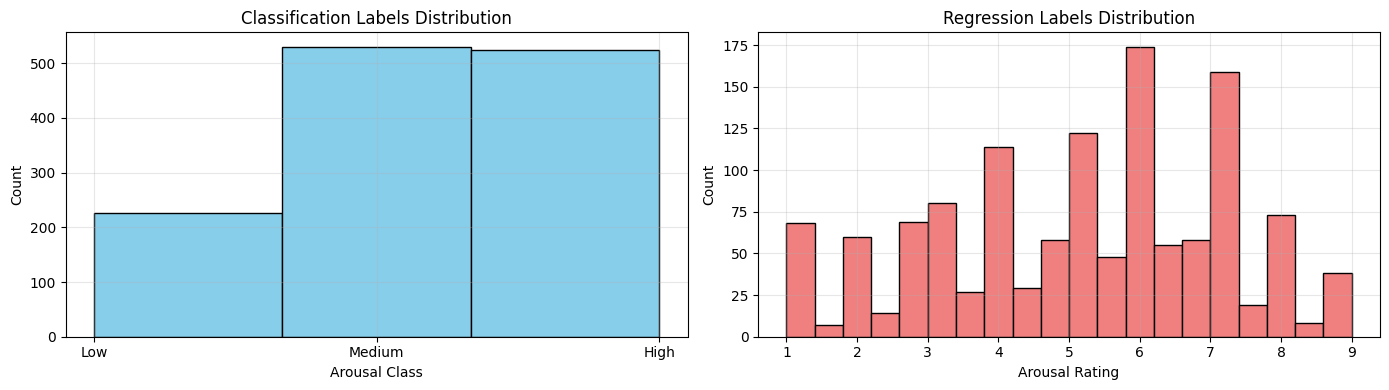


✓ Label distribution:
   Low arousal (0):    226 samples
   Medium arousal (1): 530 samples
   High arousal (2):   524 samples


In [30]:
print(f"\n{'='*70}")
print("DATA EXPLORATION")
print(f"{'='*70}\n")

print(f"✓ Data Shape: {X_simple.shape}")
print(f"✓ Classes: {np.unique(y_clf_simple)} with distribution {np.bincount(y_clf_simple)}")
print(f"✓ Arousal range: [{y_reg_simple.min():.1f}, {y_reg_simple.max():.1f}]")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Class distribution
axes[0].hist(y_clf_simple, bins=3, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Arousal Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Classification Labels Distribution')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['Low', 'Medium', 'High'])
axes[0].grid(alpha=0.3)

# Arousal ratings distribution
axes[1].hist(y_reg_simple, bins=20, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Arousal Rating')
axes[1].set_ylabel('Count')
axes[1].set_title('Regression Labels Distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Label distribution:")
print(f"   Low arousal (0):    {np.sum(y_clf_simple == 0)} samples")
print(f"   Medium arousal (1): {np.sum(y_clf_simple == 1)} samples")
print(f"   High arousal (2):   {np.sum(y_clf_simple == 2)} samples")

In [33]:
print(f"\n{'='*70}")
print("SCALING DATA")
print(f"{'='*70}\n")

# Scale using RobustScaler (resistant to outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_selected)

print(f"✓ Data scaled using RobustScaler")
print(f"✓ Scaled data shape: {X_scaled.shape}")
print(f"✓ Feature mean: {X_scaled.mean():.6f}")
print(f"✓ Feature std: {X_scaled.std():.6f}")

# Display original class distribution
print(f"\n✓ Original class distribution:")
unique, counts = np.unique(y_clf_simple, return_counts=True)
for label, count in zip(unique, counts):
    print(f"   Class {label}: {count} samples ({count/len(y_clf_simple)*100:.1f}%)")


SCALING DATA

✓ Data scaled using RobustScaler
✓ Scaled data shape: (1280, 100)
✓ Feature mean: 0.214877
✓ Feature std: 1.173510

✓ Original class distribution:
   Class 0: 226 samples (17.7%)
   Class 1: 530 samples (41.4%)
   Class 2: 524 samples (40.9%)


# Hyperparameter Optimization

In [80]:
OPTIMIZE_HYPERPARAMS = False

if OPTIMIZE_HYPERPARAMS:
    print(f"\n{'='*70}")
    print("OPTIMIZING HYPERPARAMETERS - CLASSIFICATION (GridSearchCV)")
    print(f"{'='*70}\n")

    print("Searching for best parameters with GridSearchCV + SMOTE...")

    # Define parameter grid for classification (GridSearchCV tests ALL combinations)
    param_grid_clf = {
        'svc__kernel': ['rbf', 'linear', 'poly'],
        'svc__C': np.logspace(-2, 2),  # 5 values instead of 20 for grid
        'svc__gamma': np.logspace(-4, 0, 5),  # 5 values instead of 20 for grid
        'svc__degree': [2, 3],  # Only for poly kernel
        'svc__class_weight': ['balanced', None]
    }

    # Calculate total combinations
    total_combinations = (
        len(param_grid_clf['svc__kernel']) *
        len(param_grid_clf['svc__C']) *
        len(param_grid_clf['svc__gamma']) *
        len(param_grid_clf['svc__degree']) *
        len(param_grid_clf['svc__class_weight'])
    )
    print(f"Total parameter combinations to test: {total_combinations}")
    print(f"With 3-fold CV: {total_combinations * 3} model fits\n")

    # Create base SVC model
    svc_base = SVC(random_state=42, probability=True)

    # Cross-validation strategy
    cv_clf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Create a pipeline with SMOTE and SVC
    svc_pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=5)),
        ('svc', svc_base)
    ])

    # GridSearchCV (tests ALL combinations exhaustively)
    print("Starting GridSearchCV...\n")
    print("WARNING: GridSearchCV tests ALL combinations!")
    print(f"This may take 5-15 minutes depending on your hardware.\n")

    grid_search_clf = GridSearchCV(
        estimator=svc_pipeline,
        param_grid=param_grid_clf,
        cv=cv_clf,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Fit with progress tracking
    print("Training models with GridSearchCV + SMOTE...\n")

    total_fits = total_combinations * 3  # combinations * cv_splits
    pbar = tqdm(total=total_fits, desc="GridSearch with SMOTE", unit="fit")

    grid_search_clf.fit(X_scaled, y_clf_simple)

    pbar.close()

    best_clf_params = {key.replace('svc__', ''): val for key, val in grid_search_clf.best_params_.items()}
    best_clf_score = grid_search_clf.best_score_

    print(f"\n✓ Best parameters found for Classification (GridSearchCV + SMOTE):")
    print(f"  Kernel:       {best_clf_params['kernel']}")
    print(f"  C:            {best_clf_params['C']:.6f}")
    print(f"  Gamma:        {best_clf_params['gamma']:.6f}")
    if best_clf_params['kernel'] == 'poly':
        print(f"  Degree:       {best_clf_params['degree']}")
    print(f"  Class Weight: {best_clf_params['class_weight']}")
    print(f"  Best Score (F1-Weighted): {best_clf_score:.4f}")

    # Show top 10 parameter combinations (GridSearch finds better ones)
    print(f"\n  Top 10 parameter combinations (exhaustive search):")
    results_df = pd.DataFrame(grid_search_clf.cv_results_)
    results_df = results_df.sort_values('rank_test_score')

    for idx, (i, row) in enumerate(results_df.head(10).iterrows(), 1):
        print(f"  {row['rank_test_score']:.0f}. Score: {row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")
        # Print parameters for top 3
        if idx <= 3:
            params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
            print(f"      Params: {params}")

else:
    # Use default parameters
    best_clf_params = {
        'kernel': 'rbf',
        'C': 10,
        'gamma': 0.01,
        'class_weight': 'balanced'
    }

    print(f"\n{'='*70}")
    print("USING DEFAULT CLASSIFICATION PARAMETERS (WITH SMOTE)")
    print(f"{'='*70}\n")
    print(f"  Kernel:       {best_clf_params['kernel']}")
    print(f"  C:            {best_clf_params['C']}")
    print(f"  Gamma:        {best_clf_params['gamma']}")
    print(f"  Class Weight: {best_clf_params['class_weight']}")
    print(f"\n   Skipping optimization.")
    print(f"     Set OPTIMIZE_HYPERPARAMS=True to use GridSearchCV for better parameters.")


USING DEFAULT CLASSIFICATION PARAMETERS (WITH SMOTE)

  Kernel:       rbf
  C:            10
  Gamma:        0.01
  Class Weight: balanced

   Skipping optimization.
     Set OPTIMIZE_HYPERPARAMS=True to use GridSearchCV for better parameters.


# Model Training and Evaluation

In [81]:
from imblearn.over_sampling import SMOTE


print(f"\n{'='*70}")
print("TRAINING SVM CLASSIFICATION MODEL WITH SMOTE")
print(f"{'='*70}\n")

print(f"Training with parameters: {best_clf_params}")
print(f"Note: SMOTE will balance training set in each fold\n")

# Create SVM classifier with best parameters
svm_clf = SVC(**best_clf_params, random_state=42, probability=True)

# Cross-validation
cv_splits_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Manual cross-validation loop to apply SMOTE to each fold's training set
print("Running 5-fold cross-validation with SMOTE...\n")

cv_results_clf = {
    'test_accuracy': [],
    'test_precision_weighted': [],
    'test_recall_weighted': [],
    'test_f1_weighted': [],
    'train_accuracy': [],
    'train_precision_weighted': [],
    'train_recall_weighted': [],
    'train_f1_weighted': [],
    'smote_samples_generated': []
}

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

fold_num = 0
for train_idx, test_idx in tqdm(cv_splits_clf.split(X_scaled, y_clf_simple),
                                 total=5,
                                 desc="Cross-Validation Folds with SMOTE"):
    fold_num += 1

    # Split data
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_clf_simple[train_idx], y_clf_simple[test_idx]

    # Apply SMOTE to training set ONLY
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Get number of samples generated
    samples_generated = len(y_train_smote) - len(y_train)
    cv_results_clf['smote_samples_generated'].append(samples_generated)

    # Train on balanced training set
    model = SVC(**best_clf_params, random_state=42, probability=True)
    model.fit(X_train_smote, y_train_smote)

    # Predict on test set (original, not SMOTE)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    cv_results_clf['train_accuracy'].append(accuracy_score(y_train, y_pred_train))
    cv_results_clf['train_precision_weighted'].append(precision_score(y_train, y_pred_train, average='weighted'))
    cv_results_clf['train_recall_weighted'].append(recall_score(y_train, y_pred_train, average='weighted'))
    cv_results_clf['train_f1_weighted'].append(f1_score(y_train, y_pred_train, average='weighted'))

    cv_results_clf['test_accuracy'].append(accuracy_score(y_test, y_pred_test))
    cv_results_clf['test_precision_weighted'].append(precision_score(y_test, y_pred_test, average='weighted'))
    cv_results_clf['test_recall_weighted'].append(recall_score(y_test, y_pred_test, average='weighted'))
    cv_results_clf['test_f1_weighted'].append(f1_score(y_test, y_pred_test, average='weighted'))

# Convert to numpy arrays
for key in cv_results_clf:
    cv_results_clf[key] = np.array(cv_results_clf[key])

print(f"\n✓ Cross-validation completed with SMOTE!")


TRAINING SVM CLASSIFICATION MODEL WITH SMOTE

Training with parameters: {'kernel': 'rbf', 'C': 10, 'gamma': 0.01, 'class_weight': 'balanced'}
Note: SMOTE will balance training set in each fold

Running 5-fold cross-validation with SMOTE...



Cross-Validation Folds with SMOTE: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


✓ Cross-validation completed with SMOTE!


In [82]:
print(f"\n{'='*70}")
print("CLASSIFICATION MODEL EVALUATION (WITH SMOTE)")
print(f"{'='*70}\n")

# Extract metrics
accuracy_mean = cv_results_clf['test_accuracy'].mean()
accuracy_std = cv_results_clf['test_accuracy'].std()

precision_mean = cv_results_clf['test_precision_weighted'].mean()
precision_std = cv_results_clf['test_precision_weighted'].std()

recall_mean = cv_results_clf['test_recall_weighted'].mean()
recall_std = cv_results_clf['test_recall_weighted'].std()

f1_mean = cv_results_clf['test_f1_weighted'].mean()
f1_std = cv_results_clf['test_f1_weighted'].std()

# Print results
print("Classification Metrics (5-Fold Cross-Validation with SMOTE):\n")
print(f"  Accuracy:   {accuracy_mean:.4f} ± {accuracy_std:.4f}")
print(f"  Precision:  {precision_mean:.4f} ± {precision_std:.4f}")
print(f"  Recall:     {recall_mean:.4f} ± {recall_std:.4f}")
print(f"  F1-Score:   {f1_mean:.4f} ± {f1_std:.4f}")

# Per-fold details
print("\nPer-Fold Test Accuracy:")
for fold, acc in enumerate(cv_results_clf['test_accuracy'], 1):
    smote_gen = cv_results_clf['smote_samples_generated'][fold-1]
    print(f"  Fold {fold}: {acc:.4f} (SMOTE generated {smote_gen} samples)")

# Store results for later
clf_results_summary = {
    'accuracy': accuracy_mean,
    'precision': precision_mean,
    'recall': recall_mean,
    'f1': f1_mean,
    'cv_results': cv_results_clf
}

# SMOTE statistics
print(f"\nSMOTE Statistics:")
print(f"  Average samples generated per fold: {cv_results_clf['smote_samples_generated'].mean():.0f}")
print(f"  Total samples generated: {cv_results_clf['smote_samples_generated'].sum():.0f}")

print(f"\n✓ Classification evaluation completed")


CLASSIFICATION MODEL EVALUATION (WITH SMOTE)

Classification Metrics (5-Fold Cross-Validation with SMOTE):

  Accuracy:   0.4820 ± 0.0132
  Precision:  0.5038 ± 0.0115
  Recall:     0.4820 ± 0.0132
  F1-Score:   0.4871 ± 0.0122

Per-Fold Test Accuracy:
  Fold 1: 0.4648 (SMOTE generated 248 samples)
  Fold 2: 0.4766 (SMOTE generated 248 samples)
  Fold 3: 0.4766 (SMOTE generated 248 samples)
  Fold 4: 0.4883 (SMOTE generated 248 samples)
  Fold 5: 0.5039 (SMOTE generated 248 samples)

SMOTE Statistics:
  Average samples generated per fold: 248
  Total samples generated: 1240

✓ Classification evaluation completed



CLASSIFICATION VISUALIZATION (WITH SMOTE)

Generating predictions for visualization...


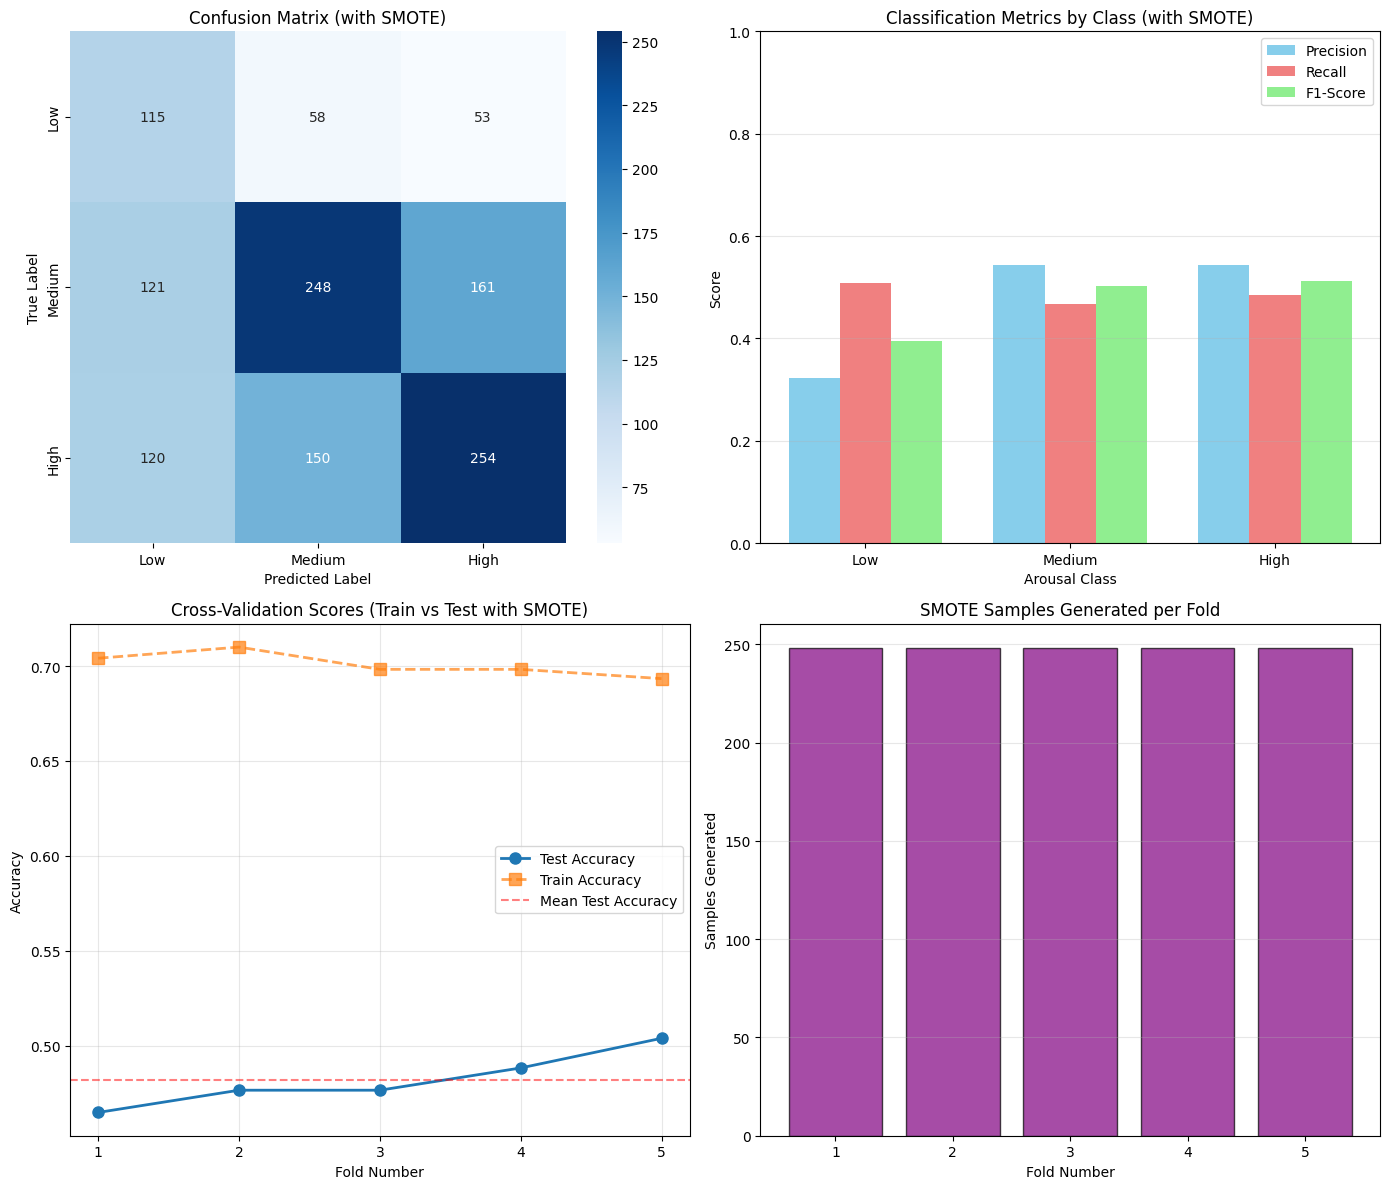

Classification report:
              precision    recall  f1-score   support

         Low       0.32      0.51      0.40       226
      Medium       0.54      0.47      0.50       530
        High       0.54      0.48      0.51       524

    accuracy                           0.48      1280
   macro avg       0.47      0.49      0.47      1280
weighted avg       0.50      0.48      0.49      1280


✓ Classification visualization completed


In [83]:
from imblearn.pipeline import Pipeline as ImbPipeline


print(f"\n{'='*70}")
print("CLASSIFICATION VISUALIZATION (WITH SMOTE)")
print(f"{'='*70}\n")


print("Generating predictions for visualization...")

# Create pipeline with SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
svm_clf_final = SVC(**best_clf_params, random_state=42, probability=True)

pipeline = ImbPipeline([
    ('smote', smote),
    ('svc', svm_clf_final)
])

# Get predictions (cross_val_predict works with pipeline)
y_pred_clf = cross_val_predict(
    pipeline,
    X_scaled, y_clf_simple,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_clf_simple, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], cbar=True)
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_title('Confusion Matrix (with SMOTE)')
axes[0, 0].set_xticklabels(['Low', 'Medium', 'High'])
axes[0, 0].set_yticklabels(['Low', 'Medium', 'High'])

# 2. Classification metrics by class
report = classification_report(y_clf_simple, y_pred_clf,
                               target_names=['Low', 'Medium', 'High'],
                               output_dict=True)

classes_names = ['Low', 'Medium', 'High']
precision_scores = [report[name]['precision'] for name in classes_names]
recall_scores = [report[name]['recall'] for name in classes_names]
f1_scores = [report[name]['f1-score'] for name in classes_names]

x = np.arange(len(classes_names))
width = 0.25

axes[0, 1].bar(x - width, precision_scores, width, label='Precision', color='skyblue')
axes[0, 1].bar(x, recall_scores, width, label='Recall', color='lightcoral')
axes[0, 1].bar(x + width, f1_scores, width, label='F1-Score', color='lightgreen')

axes[0, 1].set_xlabel('Arousal Class')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Classification Metrics by Class (with SMOTE)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(classes_names)
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Cross-validation scores with SMOTE impact
folds = np.arange(1, 6)
axes[1, 0].plot(folds, cv_results_clf['test_accuracy'], 'o-', label='Test Accuracy', linewidth=2, markersize=8)
axes[1, 0].plot(folds, cv_results_clf['train_accuracy'], 's--', label='Train Accuracy', linewidth=2, markersize=8, alpha=0.7)
axes[1, 0].axhline(y=accuracy_mean, color='r', linestyle='--', alpha=0.5, label='Mean Test Accuracy')
axes[1, 0].set_xlabel('Fold Number')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Cross-Validation Scores (Train vs Test with SMOTE)')
axes[1, 0].set_xticks(folds)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. SMOTE samples generated per fold
axes[1, 1].bar(folds, cv_results_clf['smote_samples_generated'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Fold Number')
axes[1, 1].set_ylabel('Samples Generated')
axes[1, 1].set_title('SMOTE Samples Generated per Fold')
axes[1, 1].set_xticks(folds)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Classification report:")
print(classification_report(y_clf_simple, y_pred_clf, target_names=['Low', 'Medium', 'High']))

print(f"\n✓ Classification visualization completed")

In [84]:
print(f"\n{'='*70}")
print("COMPARISON: WITH SMOTE VS WITHOUT SMOTE")
print(f"{'='*70}\n")

# Train model WITHOUT SMOTE for comparison
print("Training model WITHOUT SMOTE for comparison...\n")

cv_splits_clf_no_smote = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_no_smote = {
    'test_accuracy': [],
    'test_f1_weighted': []
}

for train_idx, test_idx in cv_splits_clf_no_smote.split(X_scaled, y_clf_simple):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_clf_simple[train_idx], y_clf_simple[test_idx]

    model = SVC(**best_clf_params, random_state=42, probability=True)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    results_no_smote['test_accuracy'].append(accuracy_score(y_test, y_pred))
    results_no_smote['test_f1_weighted'].append(f1_score(y_test, y_pred, average='weighted'))

results_no_smote['test_accuracy'] = np.array(results_no_smote['test_accuracy'])
results_no_smote['test_f1_weighted'] = np.array(results_no_smote['test_f1_weighted'])

# Compare
print("Comparison Results:\n")
print(f"{'Metric':<20} {'WITHOUT SMOTE':<20} {'WITH SMOTE':<20} {'Improvement':<15}")
print(f"{'-'*75}")

acc_without = results_no_smote['test_accuracy'].mean()
acc_with = cv_results_clf['test_accuracy'].mean()
print(f"{'Accuracy':<20} {acc_without:.4f} ± {results_no_smote['test_accuracy'].std():.4f}  {acc_with:.4f} ± {cv_results_clf['test_accuracy'].std():.4f}  {acc_with-acc_without:+.4f}")

f1_without = results_no_smote['test_f1_weighted'].mean()
f1_with = cv_results_clf['test_f1_weighted'].mean()
print(f"{'F1-Score':<20} {f1_without:.4f} ± {results_no_smote['test_f1_weighted'].std():.4f}  {f1_with:.4f} ± {cv_results_clf['test_f1_weighted'].std():.4f}  {f1_with-f1_without:+.4f}")

print(f"\n{'Result:':<20} SMOTE {'helps' if f1_with > f1_without else 'hurts'} F1-Score by {abs(f1_with-f1_without):.4f}")


COMPARISON: WITH SMOTE VS WITHOUT SMOTE

Training model WITHOUT SMOTE for comparison...

Comparison Results:

Metric               WITHOUT SMOTE        WITH SMOTE           Improvement    
---------------------------------------------------------------------------
Accuracy             0.4805 ± 0.0168  0.4820 ± 0.0132  +0.0016
F1-Score             0.4856 ± 0.0166  0.4871 ± 0.0122  +0.0014

Result:              SMOTE helps F1-Score by 0.0014


# SVR

In [85]:
if OPTIMIZE_HYPERPARAMS:
    print(f"\n{'='*70}")
    print("OPTIMIZING HYPERPARAMETERS - REGRESSION")
    print(f"{'='*70}\n")

    print("Searching for best parameters...")

    # Define parameter distributions for regression
    param_distributions_reg = {
        'C': np.logspace(-1, 3, 20),
        'gamma': np.logspace(-4, 0, 20),
        'epsilon': np.logspace(-2, 1, 10),
        'kernel': ['rbf', 'linear', 'poly'],
        'degree': [2, 3, 4]
    }

    # Create base SVR model
    svr_base = SVR()

    # Cross-validation strategy
    cv_reg = KFold(n_splits=3, shuffle=True, random_state=42)

    # Random search
    random_search_reg = RandomizedSearchCV(
        estimator=svr_base,
        param_distributions=param_distributions_reg,
        n_iter=20,
        cv=cv_reg,
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    # Fit
    print("This may take 2-3 minutes...")
    random_search_reg.fit(X_scaled, y_reg)

    best_reg_params = random_search_reg.best_params_
    best_reg_score = random_search_reg.best_score_

    print(f"\n✓ Best parameters found for Regression:")
    print(f"  Kernel: {best_reg_params['kernel']}")
    print(f"  C: {best_reg_params['C']:.6f}")
    print(f"  Gamma: {best_reg_params['gamma']:.6f}")
    print(f"  Epsilon: {best_reg_params['epsilon']:.6f}")
    if best_reg_params['kernel'] == 'poly':
        print(f"  Degree: {best_reg_params['degree']}")
    print(f"  Best Score (R²): {best_reg_score:.4f}")

else:
    # Use default parameters
    best_reg_params = {
        'kernel': 'rbf',
        'C': 100,
        'gamma': 0.001,
        'epsilon': 0.1
    }
    print(f"\nUsing default regression parameters (optimization disabled)")
    print(f"  Kernel: {best_reg_params['kernel']}")
    print(f"  C: {best_reg_params['C']}")
    print(f"  Gamma: {best_reg_params['gamma']}")
    print(f"  Epsilon: {best_reg_params['epsilon']}")


Using default regression parameters (optimization disabled)
  Kernel: rbf
  C: 100
  Gamma: 0.001
  Epsilon: 0.1


In [87]:
print(f"\n{'='*70}")
print("TRAINING SVR REGRESSION MODEL")
print(f"{'='*70}\n")

print(f"Training with parameters: {best_reg_params}")

# Create SVR with best parameters
svr_model = SVR(**best_reg_params)

# Cross-validation
cv_splits_reg = KFold(n_splits=5, shuffle=True, random_state=42)

# Define custom RMSE scorer
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Train and get cross-validation scores
print("Running 5-fold cross-validation...")
cv_results_reg = cross_validate(
    svr_model, X_scaled, y_reg_simple,
    cv=cv_splits_reg,
    scoring={'rmse': rmse_scorer, 'mae': 'neg_mean_absolute_error', 'r2': 'r2'},
    return_train_score=True,
    n_jobs=-1
)

print(f"\n✓ Cross-validation completed!")


TRAINING SVR REGRESSION MODEL

Training with parameters: {'kernel': 'rbf', 'C': 100, 'gamma': 0.001, 'epsilon': 0.1}
Running 5-fold cross-validation...

✓ Cross-validation completed!


In [88]:
print(f"\n{'='*70}")
print("REGRESSION MODEL EVALUATION")
print(f"{'='*70}\n")

# Extract metrics (convert negative values back to positive)
rmse_mean = -cv_results_reg['test_rmse'].mean()
rmse_std = cv_results_reg['test_rmse'].std()

mae_mean = -cv_results_reg['test_mae'].mean()
mae_std = cv_results_reg['test_mae'].std()

r2_mean = cv_results_reg['test_r2'].mean()
r2_std = cv_results_reg['test_r2'].std()

# Print results
print("Regression Metrics (5-Fold Cross-Validation):\n")
print(f"  RMSE:     {rmse_mean:.4f} ± {rmse_std:.4f}")
print(f"  MAE:      {mae_mean:.4f} ± {mae_std:.4f}")
print(f"  R² Score: {r2_mean:.4f} ± {r2_std:.4f}")

# Per-fold details
print("\nPer-Fold R² Score:")
for fold, r2 in enumerate(cv_results_reg['test_r2'], 1):
    print(f"  Fold {fold}: {r2:.4f}")

# Store results for later
reg_results_summary = {
    'rmse': rmse_mean,
    'mae': mae_mean,
    'r2': r2_mean,
    'cv_results': cv_results_reg
}

print(f"\n✓ Regression evaluation completed")


REGRESSION MODEL EVALUATION

Regression Metrics (5-Fold Cross-Validation):

  RMSE:     2.0166 ± 0.0787
  MAE:      1.6052 ± 0.0618
  R² Score: -0.0035 ± 0.0712

Per-Fold R² Score:
  Fold 1: -0.1279
  Fold 2: 0.0603
  Fold 3: -0.0117
  Fold 4: -0.0103
  Fold 5: 0.0721

✓ Regression evaluation completed



REGRESSION VISUALIZATION

Generating predictions for visualization...


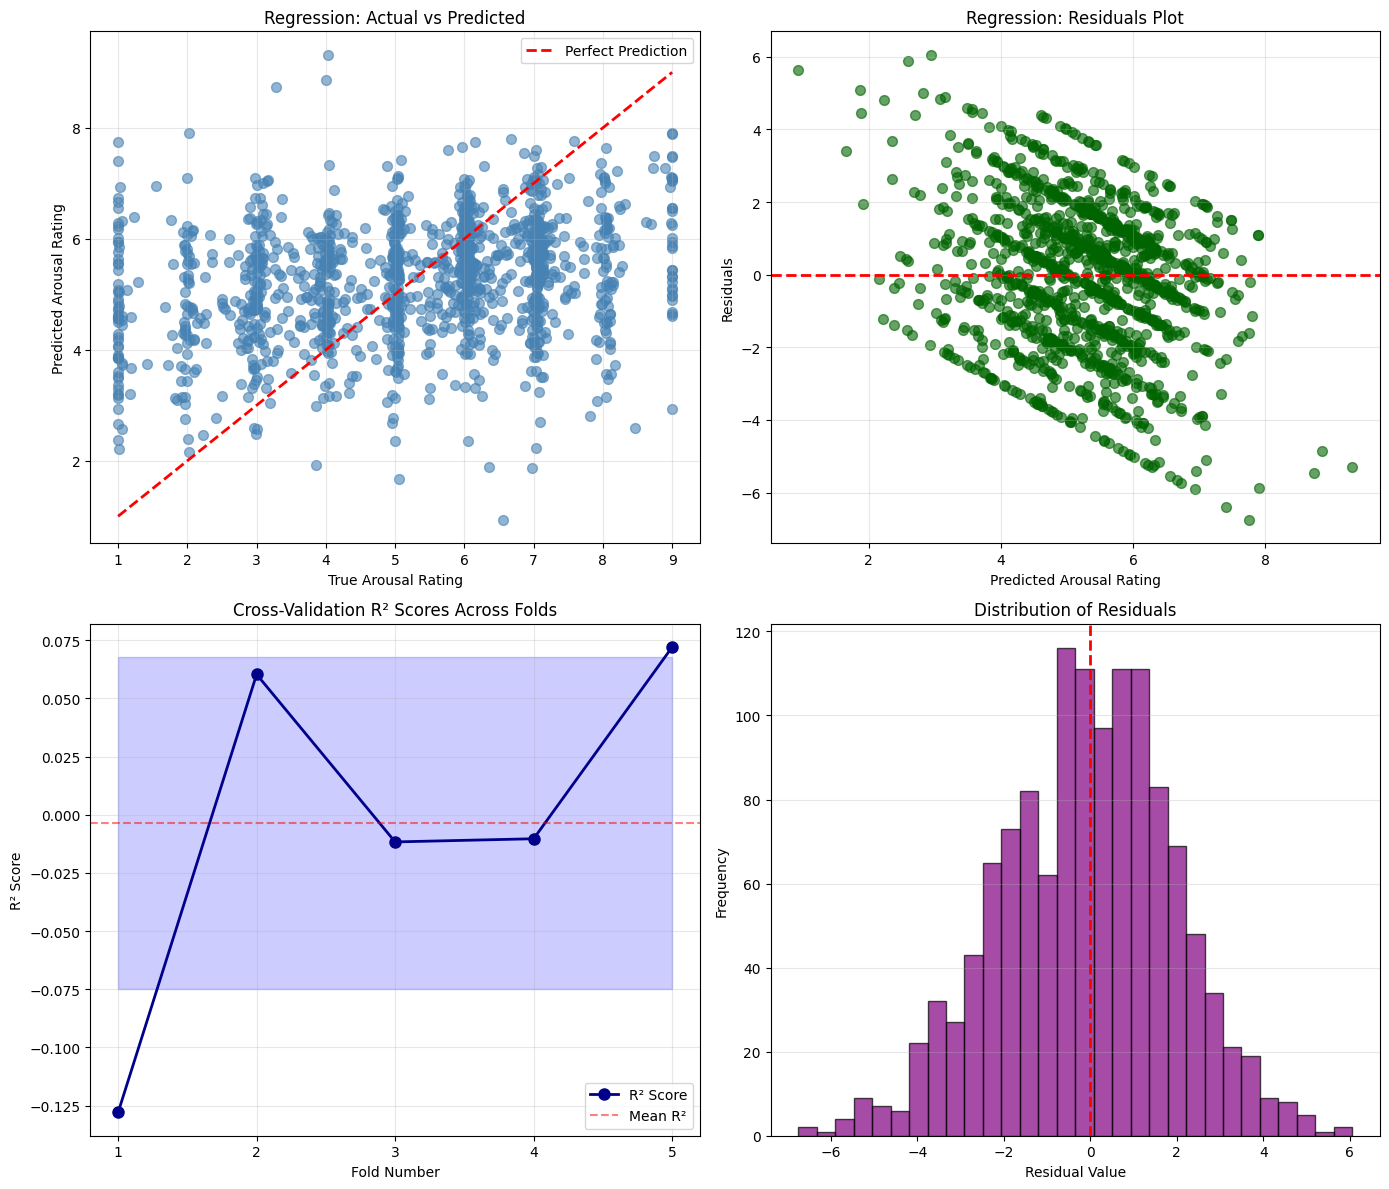


✓ Regression visualization completed


In [91]:
print(f"\n{'='*70}")
print("REGRESSION VISUALIZATION")
print(f"{'='*70}\n")

# Get predictions using cross-validation
print("Generating predictions for visualization...")

y_pred_reg = cross_val_predict(
    SVR(**best_reg_params),
    X_scaled, y_reg_simple,
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_reg_simple, y_pred_reg, alpha=0.6, color='steelblue', s=50)
axes[0, 0].plot([y_reg_simple.min(), y_reg_simple.max()], [y_reg_simple.min(), y_reg_simple.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('True Arousal Rating')
axes[0, 0].set_ylabel('Predicted Arousal Rating')
axes[0, 0].set_title('Regression: Actual vs Predicted')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Residuals plot
residuals = y_reg_simple - y_pred_reg
axes[0, 1].scatter(y_pred_reg, residuals, alpha=0.6, color='darkgreen', s=50)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Arousal Rating')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Regression: Residuals Plot')
axes[0, 1].grid(alpha=0.3)

# 3. Cross-validation scores
folds = np.arange(1, 6)
axes[1, 0].plot(folds, cv_results_reg['test_r2'], 'o-', label='R² Score', linewidth=2, markersize=8, color='darkblue')
axes[1, 0].axhline(y=r2_mean, color='r', linestyle='--', alpha=0.5, label='Mean R²')
axes[1, 0].fill_between(folds, r2_mean - r2_std, r2_mean + r2_std, alpha=0.2, color='blue')
axes[1, 0].set_xlabel('Fold Number')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Cross-Validation R² Scores Across Folds')
axes[1, 0].set_xticks(folds)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Residuals distribution
axes[1, 1].hist(residuals, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residual Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Regression visualization completed")

# REGRESSION METRICS


FEATURE IMPORTANCE ANALYSIS



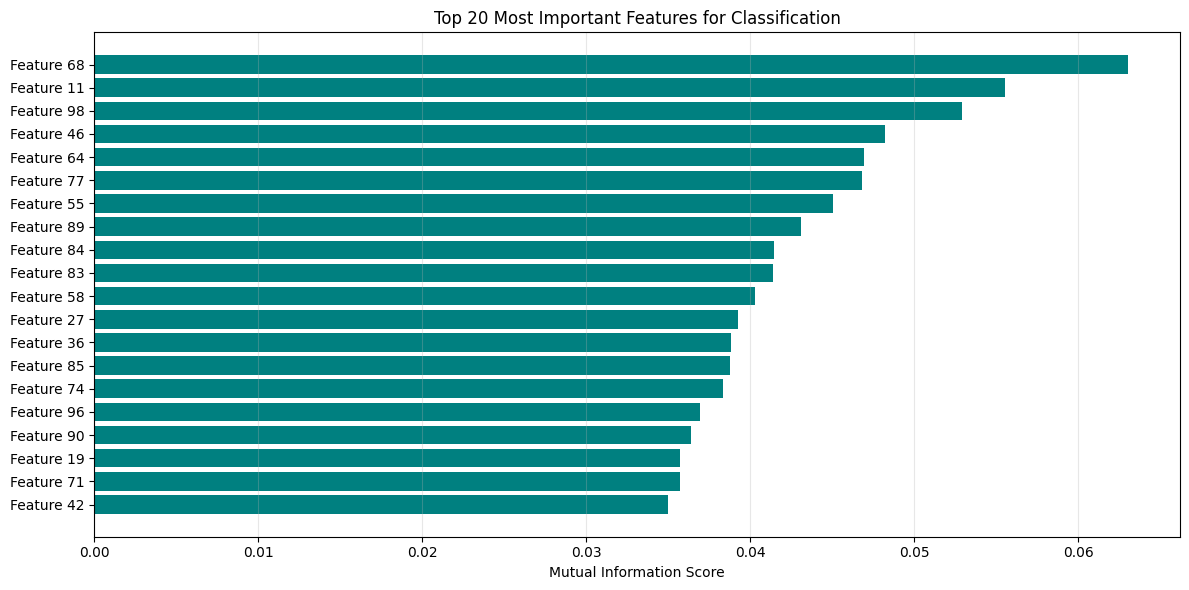

Top 20 feature importance scores:
   1. Feature 42: 0.0350
   2. Feature 71: 0.0357
   3. Feature 19: 0.0357
   4. Feature 90: 0.0364
   5. Feature 96: 0.0370
   6. Feature 74: 0.0383
   7. Feature 85: 0.0388
   8. Feature 36: 0.0388
   9. Feature 27: 0.0392
  10. Feature 58: 0.0403
  11. Feature 83: 0.0414
  12. Feature 84: 0.0414
  13. Feature 89: 0.0431
  14. Feature 55: 0.0451
  15. Feature 77: 0.0468
  16. Feature 64: 0.0469
  17. Feature 46: 0.0482
  18. Feature 98: 0.0529
  19. Feature 11: 0.0555
  20. Feature 68: 0.0631

✓ Feature importance analysis completed


In [94]:
print(f"\n{'='*70}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*70}\n")

# Calculate feature importance using mutual information
mi_scores = mutual_info_classif(X_selected, y_clf_simple, random_state=42)

# Sort and get top features
top_k = 20
top_indices = np.argsort(mi_scores)[-top_k:]
top_mi_scores = mi_scores[top_indices]

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(range(top_k), top_mi_scores, color='teal')
plt.yticks(range(top_k), [f'Feature {i}' for i in top_indices])
plt.xlabel('Mutual Information Score')
plt.title('Top 20 Most Important Features for Classification')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"Top 20 feature importance scores:")
for i, (idx, score) in enumerate(zip(top_indices, top_mi_scores), 1):
    print(f"  {i:2d}. Feature {idx}: {score:.4f}")

print(f"\n✓ Feature importance analysis completed")